In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pinkrigs_tools.dataset.query import load_data, queryCSV
import os
import glob
from scipy.io import loadmat
from scipy.ndimage import gaussian_filter1d
from random import randint
from scipy import stats
from IPython import display
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
import matplotlib.colors as mcolors
from scipy import ndimage
import matplotlib.path as mpath
from scipy.spatial import ConvexHull
from sklearn.cluster import DBSCAN
from random import randint
from scipy import optimize
import cv2
from IPython.display import display
from scipy.stats import zscore
from statsmodels.stats.multitest import fdrcorrection


In [4]:
# ASSIGN LATER TO DATA LOADING FUNCTIONS
# yoyo


def load_ONE(subject_id, date):
    # Load only specified components
    data = load_data(
    subject=subject_id,
    expDate=date,
    data_name_dict= 'all-default',
    )
        
    return data


def get_experiment_path(data):
    exp_idx = data.index[data.expDef.isin(['spontaneousActivity'])][0]
    exp_folder = data.loc[exp_idx, 'expFolder']
    exp_num = data.loc[exp_idx, 'expNum']
    return exp_folder, exp_num

def get_timestamps(exp_kwargs, rigName='poppy-stim'):
    data_name_dict = {'topCam':{'camera':['times','ROIMotionEnergy']}}
    recordings = load_data(data_name_dict=data_name_dict,**exp_kwargs)
    stim_recordings = recordings[recordings['rigName'] == rigName]
    timestamps = stim_recordings['topCam'].iloc[0]['camera'].times
    start_time = np.where(timestamps >=0)[0][0]
    timestamps[:start_time] = np.nan
    timestamps = timestamps.flatten()
    
    return start_time, timestamps

def create_time_bins(timestamps, start_time, bin_size=0.1):
   
    time_bins = np.arange(timestamps[start_time], timestamps[-1], bin_size)
    bin_centers = (time_bins[:-1] + time_bins[1:]) / 2
    bin_width = bin_centers[1] - bin_centers[0]
    return time_bins, bin_centers, bin_width


def get_DLC_data (subject_id, date, start_time):
        dlc_df = pd.read_hdf(fr'\\znas\Lab\Share\Maja\labelled_DLC_videos\{subject_id}_{date}DLC_resnet50_downsampled_trialJul11shuffle1_150000_filtered.h5')
        dlc_df = dlc_df.iloc[start_time:]
        scorer = dlc_df.columns.get_level_values('scorer')

        return dlc_df, scorer


def load_probes(exp_kwargs, rigName='poppy-stim'):
    ephys_dict = {'spikes':'all','clusters':'all'}
    
    data_name_dict = {'probe0':ephys_dict,'probe1':ephys_dict}
    
    recordings = load_data(data_name_dict=data_name_dict,**exp_kwargs)
    stim_recordings = recordings[recordings['rigName'] == rigName]
    
    try:
        spikes_0 = stim_recordings['probe0'].iloc[0]['spikes']['times'] 
        clusters_0 = stim_recordings['probe0'].iloc[0]['spikes']['clusters']  
    except (KeyError, IndexError, AttributeError):
        spikes_0 = None
        clusters_0 = None
        print('No probe0 data found')
    
    try:
        spikes_1 = stim_recordings['probe1'].iloc[0]['spikes']['times']  
        clusters_1 = stim_recordings['probe1'].iloc[0]['spikes']['clusters']  
    except (KeyError, IndexError, AttributeError):
        spikes_1 = None
        clusters_1 = None
        print('No probe1 data found')
    
    return spikes_0, clusters_0, spikes_1, clusters_1


def get_rotary_metadata(exp_folder, bin_centers):
        try:
            TICKS_PER_CYCLE = 1024
            rotary = np.load(os.path.join(exp_folder, 'rotaryEncoder.raw.npy'), allow_pickle=True)
            rotary = rotary.flatten()
            rotary[rotary > 2**31] = rotary[rotary > 2**31] - 2**32
            
            timeline_file = glob.glob(os.path.join(exp_folder, f'*_Timeline.mat'))[0]   
            time = loadmat(timeline_file)
            rotary_timestamps = time['Timeline']['rawDAQTimestamps'].item()[0, :]
            rotary_position = 360* rotary / (TICKS_PER_CYCLE*4)
            unwrapped_rotary_position = np.unwrap(rotary_position * np.pi/180) * 180/np.pi 
            rotary_position = np.interp(bin_centers,rotary_timestamps, unwrapped_rotary_position)

            return rotary_timestamps, rotary_position
            

        except Exception as e:
            print(f"Error accessing {exp_folder}: {e}")
            
        return None, None


In [255]:



def calculate_median_position(dlc_df, scorer, BODYPARTS = ['neck', 'mid_back', 'mouse_center', 'mid_backend', 'mid_backend2', 'mid_backend3']):


    
    bodypart_positions = dlc_df.loc[:, (scorer, BODYPARTS, slice(None))]
    

    
    likelihood_values = bodypart_positions.xs('likelihood', level='coords', axis=1)
    low_filter = likelihood_values <= 0.95
    strong_x = bodypart_positions.xs('x', level='coords', axis=1)  # Define first
    strong_y = bodypart_positions.xs('y', level='coords', axis=1) 
    strong_x[low_filter] = np.nan
    strong_y[low_filter] = np.nan
    strong_x = strong_x.interpolate(method='linear', axis=0)
    strong_y = strong_y.interpolate(method='linear', axis=0)
    x = strong_x.median(axis=1)
    y = strong_y.median(axis=1)
    
    return  x, y

def bin_median_positions(x, y,timestamps, start_time, bin_centers): 
    binned_x = np.interp(bin_centers, np.linspace(timestamps[start_time], timestamps[-1], len(x)), x)
    binned_y = np.interp(bin_centers, np.linspace(timestamps[start_time], timestamps[-1], len(y)), y)
    return binned_x, binned_y
    

def calculate_velocity(binned_x, binned_y, bin_width):
    
    distances = np.sqrt(np.diff(binned_x)**2 + np.diff(binned_y)**2)
    max_distance = np.percentile(distances, 99)  
    distances[distances > max_distance] = np.nan
    valid_indices = np.where(~np.isnan(distances))[0]
    distances = np.interp(
    np.arange(len(distances)),  
    valid_indices,              
    distances[valid_indices]    
)
    velocity_pix = distances / bin_width
    conversion_factor = 0.07 
    velocity = velocity_pix * conversion_factor
    velocity = gaussian_filter1d(velocity, 3)
    velocity = np.concatenate(([velocity[0] if len(velocity) > 0 else 0], velocity)) 
    return velocity




def calculate_wheel_velocity(rotary_position, bin_width, wheel_diameter=10):
    wheel_circumference = np.pi * wheel_diameter
    linear_distance_cm = np.diff(rotary_position) * wheel_circumference / 360 
    wheel_velocity = np.abs(linear_distance_cm / bin_width) 
    wheel_velocity = gaussian_filter1d(wheel_velocity, 3)
    wheel_velocity = np.concatenate(([wheel_velocity[0] if len(wheel_velocity) > 0 else 0], wheel_velocity))
    return wheel_velocity


        
     





In [327]:
# WORK IN PROGRESS


def get_spike_hist(spike_times, spike_clusters,time_bins):

    spike_counts, _, _ = np.histogram2d(
        spike_clusters, 
        spike_times,
        bins=[np.arange(0, len(np.unique(spike_clusters))+1), time_bins],
        )
    return spike_counts

def normalize_spike_counts(spike_counts):
    spike_counts = (spike_counts - np.mean(spike_counts, axis=1, keepdims=True)) / np.std(spike_counts, axis=1, keepdims=True)
    return spike_counts


def filter_spike_counts(spike_counts, arena_mask, wheel_mask):
     arena_var = np.var(spike_counts[:, arena_mask], axis=1)
     wheel_var = np.var(spike_counts[:, wheel_mask], axis=1)

     zero_var = (arena_var == 0) | (wheel_var == 0)
     spike_counts_filtered = spike_counts[~zero_var, :]

     return spike_counts_filtered

def get_correlations(spike_counts_filtered, velocity, wheel_velocity, arena_mask, wheel_mask, filter=True):
    arena_corrs = np.zeros(spike_counts_filtered.shape[0])
    wheel_corrs = np.zeros(spike_counts_filtered.shape[0])

    for i in range(spike_counts_filtered.shape[0]):
    # Free running correlation
        arena_corrs[i] = np.corrcoef(velocity[arena_mask], spike_counts_filtered[i, arena_mask])[0, 1]
        
        # Wheel running correlation
        wheel_corrs[i] = np.corrcoef(wheel_velocity[wheel_mask], spike_counts_filtered[i, wheel_mask])[0, 1]

    if filter:
        corrs_nan =  np.isnan(wheel_corrs) | np.isnan(arena_corrs)
        wheel_corrs = wheel_corrs[~corrs_nan]
        arena_corrs = arena_corrs[~corrs_nan]

    return arena_corrs, wheel_corrs

def get_cross_context_correlations(arena_corrs, wheel_corrs):

    valid = ~(np.isnan(wheel_corrs) | np.isnan(arena_corrs))
    cross_context_corr = np.corrcoef(arena_corrs[valid], wheel_corrs[valid])[0,1]

    return cross_context_corr

def plot_correlation_histogram(corrs):
    plt.figure(figsize=(12, 6))
    plt.hist(corrs, bins= 100, alpha=0.7)
    plt.xlabel('Correlation Coefficient', fontsize=18)
    plt.ylabel('Frequency', fontsize=18)
    plt.xticks( fontsize=16)
    plt.yticks( fontsize=16)
    plt.show()

def plot_sorted_spike_counts(sorting_argument, velocity, wheel_velocity, wheel_mask, arena_mask, spike_counts, w_start=0, w_end=1500):
     # Sort neurons by correlation
    sorted_idx = np.argsort(sorting_argument)[::-1]
    spike_counts = normalize_spike_counts(spike_counts)
    sorted_spike_counts = spike_counts[sorted_idx, :]
    
    # Prepare velocity data for plotting
    velocity[~arena_mask] = 0
    wheel_velocity[~wheel_mask] = 0
    
    # Create figure with three panels
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(20, 12), 
                                       gridspec_kw={'height_ratios': [1, 1, 3]},
                                       sharex=True)
    
    # Plot velocities
    ax1.plot(velocity[w_start:w_end], color='green', alpha=0.8)
    ax1.set_xticklabels([])
    ax1.set_xticks([])
    ax1.set_yticks([])
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    ax1.spines['bottom'].set_visible(False)
    ax1.spines['left'].set_visible(False)
   #ax1.set_ylabel('Free Running Velocity (cm/s)', color='green')

    ax2.plot(wheel_velocity[w_start:w_end], color='purple', alpha=0.8)
    ax2.set_xticklabels([])
    ax2.set_xticks([])
    ax2.set_yticks([])
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.spines['bottom'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    #ax2.set_ylabel('Wheel Running Velocity (cm/s)', color='purple')

    ax3.matshow(sorted_spike_counts[:, w_start:w_end], aspect= 'auto', cmap='gray_r', vmin=0, vmax=np.percentile(spike_counts, 90))
    ax3.set_yticks([])
    plt.tight_layout()
    plt.show()
    
    

    plt.tight_layout()

def plot_wheel_arena_corr(arena_corrs, wheel_corrs):
    id_corr = np.corrcoef(arena_corrs, wheel_corrs)[0, 1]
    print(f'Correlation between free and wheel running neurons: {id_corr}')

    plt.figure(figsize=(10, 8))
    plt.scatter(arena_corrs, wheel_corrs, alpha=0.5)
    plt.xlabel('Open Arena Correlation Coefficient', fontsize=18)
    plt.ylabel('Wheel Running Correlation Coefficient', fontsize=18)
    plt.axhline(0, color='gray', linestyle='--')
    plt.axvline(0, color='gray', linestyle='--')
    plt.xlim(-0.5, 0.5)
    plt.ylim(-0.5, 0.5)
    plt.xticks(np.arange(-0.5, 0.51, 0.25), fontsize=16)
    plt.yticks(np.arange(-0.5, 0.51, 0.25), fontsize=16)
    plt.show()
        
def cross_validate_correlations(spike_counts, arena_mask,wheel_mask, velocity, wheel_velocity, time_bins, split = 2):

    midpoint =  spike_counts.shape[1] // split

    oa_train_idx = np.where(arena_mask[:midpoint])[0]
    oa_test_idx = np.where(arena_mask[midpoint:])[0] + midpoint
    wh_train_idx = np.where(wheel_mask[:midpoint])[0]
    wh_test_idx = np.where(wheel_mask[midpoint:])[0] + midpoint

    oa_train_var = np.var(spike_counts[:, oa_train_idx], axis=1)
    oa_test_var = np.var(spike_counts[:, oa_test_idx], axis=1)
    wh_train_var = np.var(spike_counts[:, wh_train_idx], axis=1)
    wh_test_var = np.var(spike_counts[:, wh_test_idx], axis=1)
    
    # Remove neurons with zero variance in any split
    good_neurons = ~((oa_train_var == 0) | (oa_test_var == 0) | 
                     (wh_train_var == 0) | (wh_test_var == 0))
    
    spike_counts = spike_counts[good_neurons, :]
    n_neurons = spike_counts.shape[0]

    train_corr_arena = np.zeros(n_neurons)
    test_corr_arena = np.zeros(n_neurons)
    train_corr_wheel = np.zeros(n_neurons)
    test_corr_wheel = np.zeros(n_neurons)

    for i in range(n_neurons):
        try:
            train_corr_arena[i] = np.corrcoef(spike_counts[i,oa_train_idx], velocity[oa_train_idx])[0,1]
            test_corr_arena[i] = np.corrcoef (spike_counts[i,oa_test_idx],velocity [oa_test_idx])[0,1]
            train_corr_wheel[i] = np.corrcoef(spike_counts[i,wh_train_idx], wheel_velocity[wh_train_idx])[0,1]
            test_corr_wheel[i] = np.corrcoef(spike_counts[i, wh_test_idx], wheel_velocity[wh_test_idx])[0,1]

        except Exception as e:
            pass

    
    oa_stability = np.corrcoef(train_corr_arena, test_corr_arena)[0,1]
    wh_stability = np.corrcoef(train_corr_wheel, test_corr_wheel)[0,1]

    return train_corr_arena, test_corr_arena, train_corr_wheel, test_corr_wheel, oa_stability, wh_stability
    

def plot_cross_validation(train_corr_arena, test_corr_arena, train_corr_wheel, test_corr_wheel, oa_stability, wh_stability):

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.scatter(train_corr_arena, test_corr_arena, alpha=0.5)
    
       
        plt.axhline(0, color='gray', linestyle='--')
        plt.axvline(0, color='gray', linestyle='--')
        plt.xticks(np.arange(-1, 1.1, 0.4), fontsize=16)
        plt.yticks(np.arange(-1, 1.1, 0.4), fontsize=16)
        plt.xlim(-1, 1)
        plt.ylim(-1, 1)
        plt.title(f'correlation train/test arena r={oa_stability}')
       

        plt.subplot(1, 2, 2)
        plt.scatter(train_corr_wheel, test_corr_wheel, alpha=0.5)
        plt.axhline(0, color='gray', linestyle='--')
        plt.axvline(0, color='gray', linestyle='--')
        plt.xticks(np.arange(-1, 1.1, 0.4), fontsize=16)
        plt.yticks(np.arange(-1, 1.1, 0.4), fontsize=16)
        plt.xlim(-1, 1)
        plt.ylim(-1, 1)
        plt.tight_layout()
        plt.title(f'correlation train/test wheel r={wh_stability}')
        plt.show()



    



    

In [234]:
def get_ROI(subject_id, date):
    frame_idx = 0

    cap = cv2.VideoCapture(fr'\\znas\Lab\Share\Maja\labelled_DLC_videos\{subject_id}_{date}.mp4')
    while frame_idx < 10: 

        ret, frame = cap.read()
        if not ret:
            break
        frame_idx += 1
        
        preprocessed_frame = preprocess_frame(frame)
        circles = cv2.HoughCircles(preprocessed_frame, cv2.HOUGH_GRADIENT, dp=1.5, param1=50, param2= 20,minDist=90, minRadius=104, maxRadius=110)

        xy_list = []
        r_list = []
        if circles is not None:
            
            # Convert the (x, y) coordinates and radius of the circles to integers
            circles = np.uint16(np.around(circles))
            x, y, r = circles[0][0]
            xy_list.append((x, y))
            r_list.append(r)

        if frame_idx % 10 == 0:
            print(f"Processing frame {frame_idx}/10")

    cap.release()
    cv2.destroyAllWindows()

    if len(xy_list) == 0:
        print("No circles found in the video.")
        return None, None, None, None
    
    # Get ROI center and radius
    center_x = int(np.median([xy[0] for xy in xy_list]))
    center_y = int(np.median([xy[1] for xy in xy_list]))
    radius = int(np.median(r_list))

    return frame, center_x, center_y, radius
        
        

def preprocess_frame(frame):
    gray_frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    preprocessed_frame = cv2.medianBlur(gray_frame, 21)
    return preprocessed_frame

def plot_masked_positions(binned_x, binned_y, arena_mask, wheel_mask):
    plt.figure(figsize=(12, 10))
    plt.scatter(binned_x[arena_mask], binned_y[arena_mask], c='green', s=2)
    plt.scatter(binned_x[wheel_mask], binned_y[wheel_mask], c='purple', s=2)
    plt.show


def plot_ROI(frame, center_x, center_y, radius, subject_id, date):
    # Draw the circle in the image
    cv2.circle(frame, (center_x, center_y), radius, (0, 255, 0), 2)
    # Draw a rectangle at the center of the circle
    cv2.circle(frame, (center_x, center_y), 2, (0, 255, 0), -1)

    #show results
    plt.figure(figsize=(10, 8))
    plt.title(f'{subject_id}-{date}: center: ({center_x}, {center_y}), radius: {radius}')
    plt.imshow(frame)

def get_position_masks (binned_x, binned_y, center_x, center_y, radius, subject_id):
    distances = np.sqrt((binned_x - center_x) ** 2 + (binned_y - center_y) ** 2)

    wheel_mask = distances <= radius
    wheel_mask = temporal_buffer(wheel_mask)

    
    right_corner =(
        (binned_x > center_x ) &  
        (binned_y > center_y)
    )

    left_corner = (
        (binned_x < center_x ) &  
        (binned_y < center_y)
    )   

    if not subject_id == 'GB012':
        arena_mask = ~wheel_mask & (~right_corner)

    else:
        arena_mask = ~wheel_mask & (~left_corner)

    return arena_mask, wheel_mask


def temporal_buffer(mask, buffer_size=30):
    transition_indices = np.where(np.diff(mask.astype(int)) != 0)[0] + 1
    
    for i in range(len(transition_indices) - 1):
        if transition_indices[i+1] - transition_indices[i] < buffer_size:
            if transition_indices[i] > 0:
                mask[transition_indices[i]:transition_indices[i+1]] = mask[transition_indices[i]-1]
    
    return mask

def get_speed_masks(velocity, wheel_velocity, arena_mask, wheel_mask):

    wh_running = (wheel_velocity > 1) &  ~arena_mask
    arena_velocity = velocity.copy()
    arena_velocity[~arena_mask] = 0  
    
    arena_onsets, arena_offsets = detect_bouts(
        arena_velocity,
        onset_threshold=2.0,
        offset_threshold=0.5,
        min_bout_duration=20
    )
    
    # Create arena running mask from bouts
    oa_running = np.zeros_like(velocity, dtype=bool)
    for onset, offset in zip(arena_onsets, arena_offsets):
        oa_running[onset:offset] = True
    
    oa_running = oa_running & arena_mask  
    
    return oa_running, wh_running #arena_onsets, arena_offsets




def detect_bouts(velocity, 
                 onset_threshold=2.0,      
                 offset_threshold=0.5,     
                 min_bout_duration=20,    
                 min_stable_offset=10):    
    
    onsets = np.where((velocity[:-1] < onset_threshold) & 
                      (velocity[1:] >= onset_threshold))[0] + 1
    
    if len(onsets) == 0:
        return np.array([]), np.array([])
    
    offsets = []
    for onset in onsets:

        offset_found = False
        for i in range(onset + min_bout_duration, len(velocity)):
            if i + min_stable_offset > len(velocity):
                offsets.append(len(velocity) - 1)
                offset_found = True
                break
            
            if np.all(velocity[i:i+min_stable_offset] < offset_threshold):
                offsets.append(i)
                offset_found = True
                break
        
        if not offset_found:
            offsets.append(len(velocity) - 1)
    
    offsets = np.array(offsets)
    
    bout_durations = offsets - onsets
    valid_bouts = bout_durations >= min_bout_duration
    
    return onsets[valid_bouts], offsets[valid_bouts]

In [384]:
def load_and_process_session(subject_id, date):    
    # load data
    ONE = load_ONE(subject_id, date)
    exp_folder, exp_num = get_experiment_path(ONE)
    exp_kwargs = {
        'subject': subject_id, 
        'expDate': date
    }
    start_time, timestamps = get_timestamps(exp_kwargs, rigName='poppy-stim')
    time_bins, bin_centers, bin_width = create_time_bins(timestamps, start_time)
    dlc_df, scorer = get_DLC_data(subject_id, date, start_time)
    rotary_timestamps, rotary_position = get_rotary_metadata(exp_folder, bin_centers)

    # define context
    frame, center_x, center_y, radius = get_ROI(subject_id, date)
    plot_ROI(frame, center_x, center_y, radius, subject_id, date)

    # compute velocity
    x, y = calculate_median_position(dlc_df, scorer)
    binned_x, binned_y = bin_median_positions(x, y, timestamps, start_time, bin_centers)
    velocity = calculate_velocity(binned_x, binned_y, bin_width)
    wheel_velocity = calculate_wheel_velocity(rotary_position, bin_width)
    arena_mask, wheel_mask = get_position_masks(binned_x, binned_y, center_x, center_y, radius, subject_id)
    #oa_running, wh_running = get_speed_masks(velocity, wheel_velocity, arena_mask, wheel_mask)
    # generate spike histogram 
    spikes_0, clusters_0, spikes_1, clusters_1 = load_probes(exp_kwargs)
    
    if spikes_1 is not None and clusters_1 is not None:
        
        if spikes_0 is not None and clusters_0 is not None:
            offset = np.max(clusters_0) + 1
            clusters_1 = clusters_1 + offset
            
            # Combine both probes
            spikes = np.concatenate([spikes_0, spikes_1])
            clusters = np.concatenate([clusters_0, clusters_1])
        else:
            # Only probe 1
            spikes = spikes_1
            clusters = clusters_1
    else:
        # Only probe 0
        spikes = spikes_0
        clusters = clusters_0
    
    # Create histogram as usual
    spike_counts = get_spike_hist(spikes, clusters, time_bins)
    spike_counts = filter_spike_counts(spike_counts, arena_mask, wheel_mask)

    session_data = {
        "metadata": {
            "subject_id": subject_id,
            "date":  date,
            "time_bins": time_bins
        },

        "neural_data": {
            "spike_counts": spike_counts,
        },

        "behavioral_data": {
            "binned_x": binned_x,
            "binned_y": binned_y, 
            "velocity": velocity,
            "wheel_velocity": wheel_velocity,
            "arena_mask": arena_mask,
            "wheel_mask": wheel_mask,
        },
    }
    
    return session_data

def analyze_single_session(session_data):
    """Analyze a single session's correlations and stability"""
    spike_counts = session_data["neural_data"]["spike_counts"]
    behavioral_data = session_data["behavioral_data"]
    velocity = behavioral_data["velocity"]
    wheel_velocity = behavioral_data["wheel_velocity"]
    arena_mask = behavioral_data["arena_mask"]
    wheel_mask = behavioral_data["wheel_mask"]
    time_bins = session_data["metadata"]["time_bins"]

    # Compute correlations
    arena_corrs, wheel_corrs = get_correlations(spike_counts, velocity, wheel_velocity, arena_mask, wheel_mask)
    
    # Cross-context correlation
    valid = ~(np.isnan(arena_corrs) | np.isnan(wheel_corrs))
    cross_context_corr = np.corrcoef(arena_corrs[valid], wheel_corrs[valid])[0, 1] if np.sum(valid) > 1 else np.nan
    
    # Stability
    _, _, _, _, oa_stability, wh_stability = cross_validate_correlations(
        spike_counts, arena_mask, wheel_mask, velocity, wheel_velocity, time_bins
    )

    # Add results to session data
    session_data["correlations"] = {
        "arena": arena_corrs,
        "wheel": wheel_corrs,
        "cross_context": cross_context_corr
    }
    
    session_data["stability"] = {
        "arena": oa_stability,
        "wheel": wh_stability
    }
    
    return session_data

def compute_null_distributions_for_session(session_data, other_sessions):
    """Compute null distributions for a single session using other sessions' behavior"""
    spike_counts = session_data["neural_data"]["spike_counts"]
    n_neurons = spike_counts.shape[0]
    n_null = len(other_sessions)
    
    null_arena = np.zeros((n_null, n_neurons))
    null_wheel = np.zeros((n_null, n_neurons))
    
    for i, other_session in enumerate(other_sessions):
        try:
            current_length = spike_counts.shape[1]
            null_length = len(other_session["behavioral_data"]["velocity"])
            min_length = min(current_length, null_length)
            
            null_arena[i], null_wheel[i] = get_correlations(
                spike_counts[:, :min_length],
                other_session["behavioral_data"]["velocity"][:min_length],
                other_session["behavioral_data"]["wheel_velocity"][:min_length],
                other_session["behavioral_data"]["arena_mask"][:min_length],
                other_session["behavioral_data"]["wheel_mask"][:min_length],
                filter=False
            )
        except Exception as e:
            print(f"Error computing null for session {i}: {e}")
            null_arena[i] = np.nan
            null_wheel[i] = np.nan
    
    return null_arena, null_wheel

def compute_p_values_from_null(session_data, null_arena, null_wheel):
    """Compute p-values given null distributions"""
    arena_corrs = session_data["correlations"]["arena"]
    wheel_corrs = session_data["correlations"]["wheel"]
    n_neurons = len(arena_corrs)
    n_null = null_arena.shape[0]
    
    p_values_arena = np.zeros(n_neurons)
    p_values_wheel = np.zeros(n_neurons)
    
    for n in range(n_neurons):
        # One-tailed test based on sign
        if arena_corrs[n] >= 0:
            p_values_arena[n] = np.sum(null_arena[:, n] >= arena_corrs[n]) / n_null
        else:
            p_values_arena[n] = np.sum(null_arena[:, n] <= arena_corrs[n]) / n_null
            
        if wheel_corrs[n] >= 0:
            p_values_wheel[n] = np.sum(null_wheel[:, n] >= wheel_corrs[n]) / n_null
        else:
            p_values_wheel[n] = np.sum(null_wheel[:, n] <= wheel_corrs[n]) / n_null
    
    session_data["p_values"] = {
        "arena": p_values_arena,
        "wheel": p_values_wheel
    }
    
    return session_data


def analyze_multiple_sessions(session_list):
    """Load all sessions, then compute p-values"""
    # Load all sessions
    all_sessions = []
    for subject_id, date in session_list:
        try:
            session_data = load_and_process_session(subject_id, date)
            session_data = analyze_single_session(session_data)
            all_sessions.append(session_data)
            print(f"Loaded and analyzed: {subject_id} - {date}")
        except Exception as e:
            print(f"Failed: {subject_id} - {date}: {e}")
    
    # Compute p-values for each session
    for i, session in enumerate(all_sessions):
        other_sessions = all_sessions[:i] + all_sessions[i+1:]
        if len(other_sessions) > 0:
            null_arena, null_wheel = compute_null_distributions_for_session(session, other_sessions)
            session = compute_p_values_from_null(session, null_arena, null_wheel)
            print(f"Computed p-values for session {i+1}/{len(all_sessions)}")
    
    return all_sessions


def add_p_values_to_session(session_data, other_sessions):
    """Add p-values to an already analyzed session"""
    null_arena, null_wheel = compute_null_distributions_for_session(session_data, other_sessions)
    session_data = compute_p_values_from_null(session_data, null_arena, null_wheel)
    return session_data

def plot_single_session(session_data, w_start=0, w_end=1200):

    time_bins = session_data["metadata"]["time_bins"]
    spike_counts = session_data["neural_data"]["spike_counts"]
    binned_x = session_data["behavioral_data"]["binned_x"]
    binned_y = session_data["behavioral_data"]["binned_y"]
    velocity = session_data["behavioral_data"]["velocity"]
    wheel_velocity = session_data["behavioral_data"]["wheel_velocity"]
    arena_mask = session_data["behavioral_data"]["arena_mask"]
    wheel_mask = session_data["behavioral_data"]["wheel_mask"]
    arena_corrs = session_data["correlations"]["arena"]
    wheel_corrs = session_data["correlations"]["wheel"]
    plt.hist(velocity[velocity > 0], bins=100)
    plt.xlabel('Velocity')
    plt.ylabel('Count')
    plt.axvline(1.0, color='g', label='Threshold')
    plt.legend()
    plot_masked_positions(binned_x, binned_y, arena_mask, wheel_mask)
    plot_masked_positions(binned_x[w_start:w_end], binned_y[w_start:w_end], arena_mask[w_start:w_end], wheel_mask[w_start:w_end])
    plot_sorted_spike_counts(arena_corrs, velocity, wheel_velocity, wheel_mask, arena_mask, spike_counts, w_start, w_end)
    plot_sorted_spike_counts(wheel_corrs, velocity, wheel_velocity, wheel_mask, arena_mask, spike_counts, w_start, w_end)

    plot_correlation_histogram(arena_corrs)
    plot_correlation_histogram(wheel_corrs)

    plot_wheel_arena_corr(arena_corrs, wheel_corrs)

    train_corr_arena, test_corr_arena, train_corr_wheel, test_corr_wheel, oa_stability, wh_stability = cross_validate_correlations(spike_counts, arena_mask,wheel_mask, velocity, wheel_velocity, time_bins, split = 2)
    plot_cross_validation(train_corr_arena, test_corr_arena, train_corr_wheel, test_corr_wheel, oa_stability, wh_stability)

def categorise_neurons(all_sessions, alpha=0.05):

        for session in all_sessions:
            arena_corrs =session["correlations"]["arena"]
            wheel_corrs =session["correlations"]["wheel"]
            pvals_oa = session["p_values"]["arena"]
            pvals_wh = session["p_values"]["wheel"]
            

            arena_sig,_ = fdrcorrection(pvals_oa, alpha=0.05)
            wheel_sig,_ = fdrcorrection(pvals_wh, alpha=0.05)

            categories =  {

                "context_invariant": arena_sig & wheel_sig & (np.sign(arena_corrs) == np.sign(wheel_corrs)),

                "arena_only": arena_sig & ~wheel_sig,

                "wheel_only": ~arena_sig & wheel_sig,

                "context_switching": arena_sig & wheel_sig & (np.sign(arena_corrs) != np.sign(wheel_corrs)),

                "non_encoding": ~arena_sig & ~wheel_sig,
            }

            session["categories"]= categories
        
        return all_sessions


            
def plot_all_correlation_distributions(all_sessions, n_sessions):

    
    
    x_positions_arena = []
    x_positions_wheel = []
    arena_data = []
    wheel_data = []
    labels = []

    for i, session in enumerate(all_sessions):
        arena_corrs = session["correlations"]["arena"]
        wheel_corrs = session["correlations"]["wheel"]
        
        arena_corrs = arena_corrs[~np.isnan(arena_corrs)]
        wheel_corrs = wheel_corrs[~np.isnan(wheel_corrs)]
        
        x_positions_arena.append(i*2)
        x_positions_wheel.append(i*2 + 0.8)
        
        # Store data
        arena_data.append(arena_corrs)
        wheel_data.append(wheel_corrs)
        
        # Create label
        subject = session["metadata"]["subject_id"]
        date = session["metadata"]["date"]
        labels.append(f"{subject}\n{date}")

    fig, ax1 = plt.subplots(figsize=(2*n_sessions, 8))
    violin_arena = ax1.violinplot(arena_data,positions = x_positions_arena, widths=0.7)
    

    for pc in violin_arena['bodies']:
        pc.set_facecolor('green')
        pc.set_alpha(0.7)
    

    ax1.set_xticks([i*2 + 0.8 for i in range(n_sessions)])
    ax1.set_xticklabels(labels, rotation=45, ha='right', fontsize = 18)
    ax1.set_ylabel('Correlation', fontsize=18)
    ax1.tick_params(axis='y', labelsize=18)
    ax1.set_title('Distribution of Neural Correlations in Arena by Session', fontsize=24)
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0, color='k', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.show()

    fig2, ax2 = plt.subplots(figsize=(2*n_sessions, 8))
    violin_wheel = ax2.violinplot(wheel_data, positions = x_positions_wheel, widths=0.7)

    for pc in violin_wheel['bodies']:
        pc.set_facecolor('purple')
        pc.set_alpha(0.7)

    ax2.set_xticks([i*2 + 0.8 for i in range(n_sessions)])
    ax2.set_xticklabels(labels, rotation=45, ha='right', fontsize = 18)
    ax2.tick_params(axis='y', labelsize=18)
    ax2.set_ylabel('Correlation', fontsize = 18)
    ax2.set_title('Distribution of Neural Correlations on Wheel by Session', fontsize=24)
    ax2.grid(True, alpha=0.3)
    ax2.axhline(y=0, color='k', linestyle='--', alpha=0.5)


    plt.tight_layout()
    plt.show()


def plot_all_stability(all_sessions, n_sessions):

    fig, ax = plt.subplots(figsize=(max(8, n_sessions), 8))

    x_positions= np.arange(n_sessions)
    arena_stability = []
    wheel_stability = []
    labels= []
    

    for i, session in enumerate(all_sessions):
        arena_stability.append(session["stability"]["arena"])
        wheel_stability.append(session["stability"]["wheel"])

        subject = session["metadata"]["subject_id"]
        date = session["metadata"]["date"]
        labels.append(f"{subject}\n{date}")

    ax.scatter(x_positions, arena_stability, color ='green', alpha =0.7, label = 'Arena', s=45)
    ax.scatter(x_positions, wheel_stability, color ='purple', alpha =0.7, label = 'Wheel', s=45)

    ax.set_xticks(x_positions)
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=18)
    ax.tick_params(axis='y', labelsize=18)
    ax.set_ylabel('Stability', fontsize = 18)
    ax.set_title('Neural Stability Comparison Across Sessions', fontsize=24)
    ax.grid(True, alpha=0.3)
    ax.legend()

    plt.tight_layout()
    plt.show()

def plot_all_cross_context_corrs(all_sessions, n_sessions):

    fig, ax = plt.subplots(figsize=(max(8, n_sessions), 8))

    x_positions= np.arange(n_sessions)
    cross_context = []
    labels= []
    

    for i, session in enumerate(all_sessions):
        cross_context.append(session["correlations"]["cross_context"])

        subject = session["metadata"]["subject_id"]
        date = session["metadata"]["date"]
        labels.append(f"{subject}\n{date}")

    ax.scatter(x_positions, cross_context, color ='red', alpha =0.7, label = 'Arena', s=45)
    

    ax.set_xticks(x_positions)
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize = 18)
    ax.set_ylabel('Cross-Context Correlation', fontsize = 18)
    ax.tick_params(axis='y', labelsize=18)
    ax.set_title('Cross-Context Correlation Comparison Across Sesssion', fontsize=24)
    ax.grid(True, alpha=0.3)
    ax.legend()

    plt.tight_layout()
    plt.show()

def plot_categories(all_sessions, n_sessions):

    fig, ax = plt.subplots(figsize=(max(8, n_sessions), 8))

    x_positions= np.arange(n_sessions)
    labels= []

    category_names = ["context_invariant", "arena_only", "wheel_only", 
                     "context_switching", "non_encoding"]
    
    colors = ['purple', 'pink', 'red', 'orange', 'yellow']
    
    category_counts = {name: [] for name in category_names}

    for i, session in enumerate(all_sessions):
        
        categories = session["categories"] 
        
        total_neurons = len(categories["context_invariant"])

        for cat_name in category_names:
            count = np.sum(categories[cat_name])
            proportion = count / total_neurons if total_neurons > 0 else 0
            category_counts[cat_name].append(proportion)

        subject = session["metadata"]["subject_id"]
        date = session["metadata"]["date"]
        labels.append(f"{subject}\n{date}")

    bottom = np.zeros(n_sessions)
    
    for cat_name, color in zip(category_names, colors):
        proportions = category_counts[cat_name]
        ax.bar(x_positions, proportions, bottom=bottom, 
               label=cat_name.replace('_', ' ').title(), 
               color=color, alpha=0.7, width=0.6)
        bottom += proportions

    ax.set_xticks(x_positions)
    ax.set_xticklabels(labels, rotation=45, ha='right', fontsize=12)
    ax.set_ylabel('Proportion of Neurons', fontsize=18)
    ax.set_title('Neuron Category Proportions Across Sessions', fontsize=20)
    ax.tick_params(axis='y', labelsize=14)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax.set_ylim(0, 1)

    plt.tight_layout()
    plt.show()


def plot_all_sessions(all_sessions):

    n_sessions= len(all_sessions)

    plot_all_correlation_distributions(all_sessions, n_sessions)
    plot_all_cross_context_corrs(all_sessions, n_sessions)
    plot_all_stability(all_sessions, n_sessions)
    plot_categories(all_sessions, n_sessions)
    


    



        

In [ ]:
subject_id = 'GB012'
date = '2024-0-20'

Processing frame 10/10
No probe1 data found


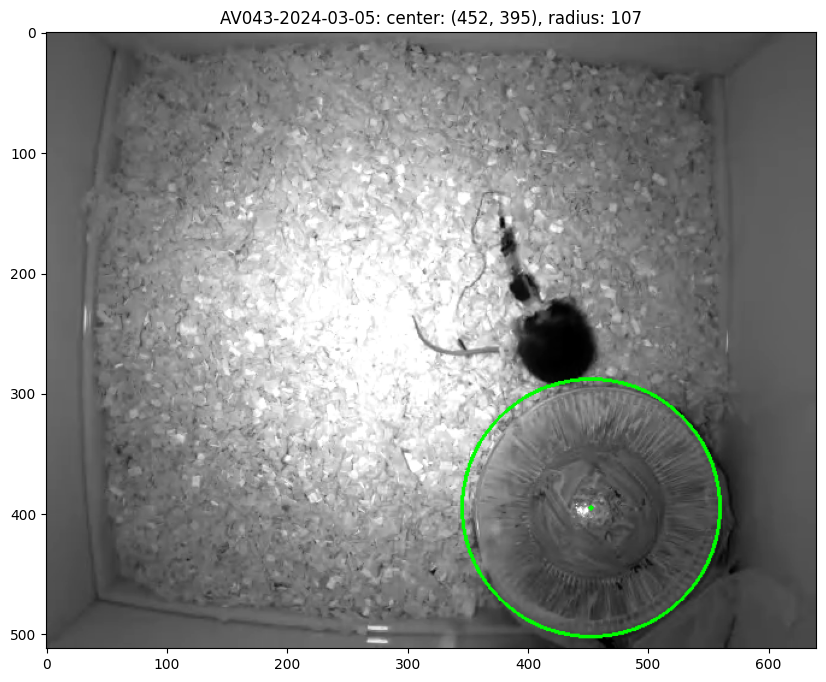

In [368]:
subject_id = 'AV043'
date = '2024-03-05'

session = load_and_process_session(subject_id, date)
session = analyze_single_session(session)

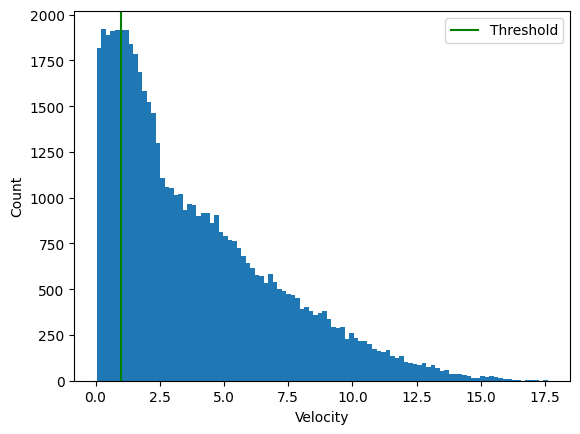

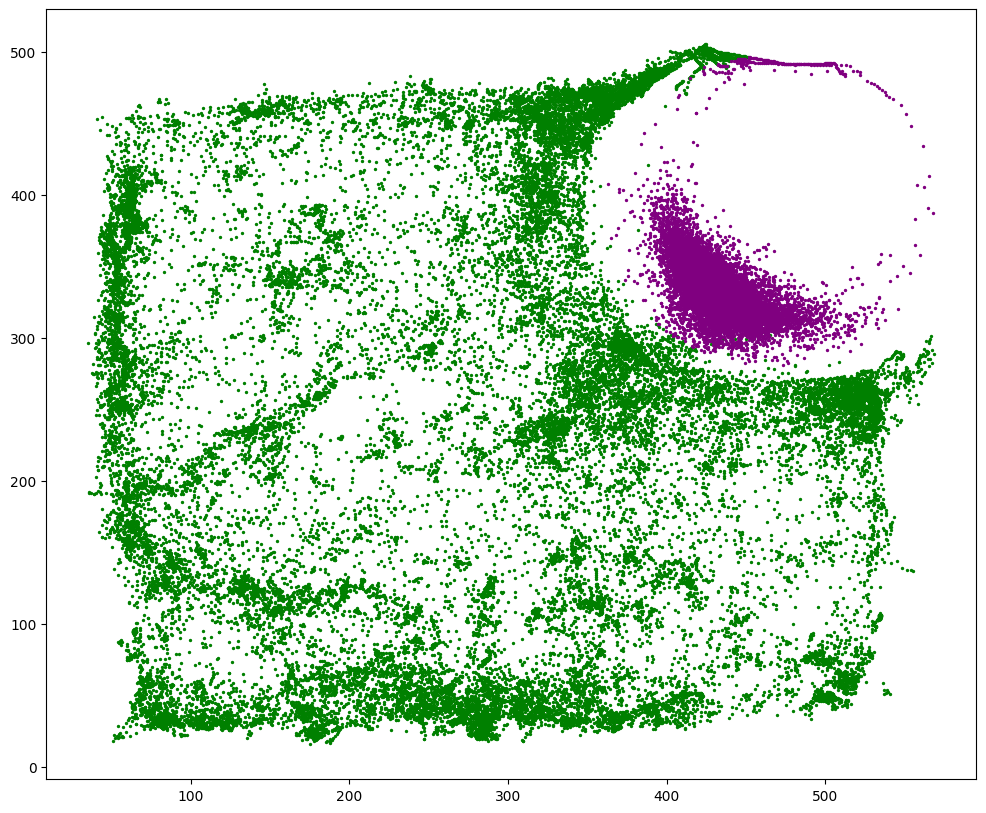

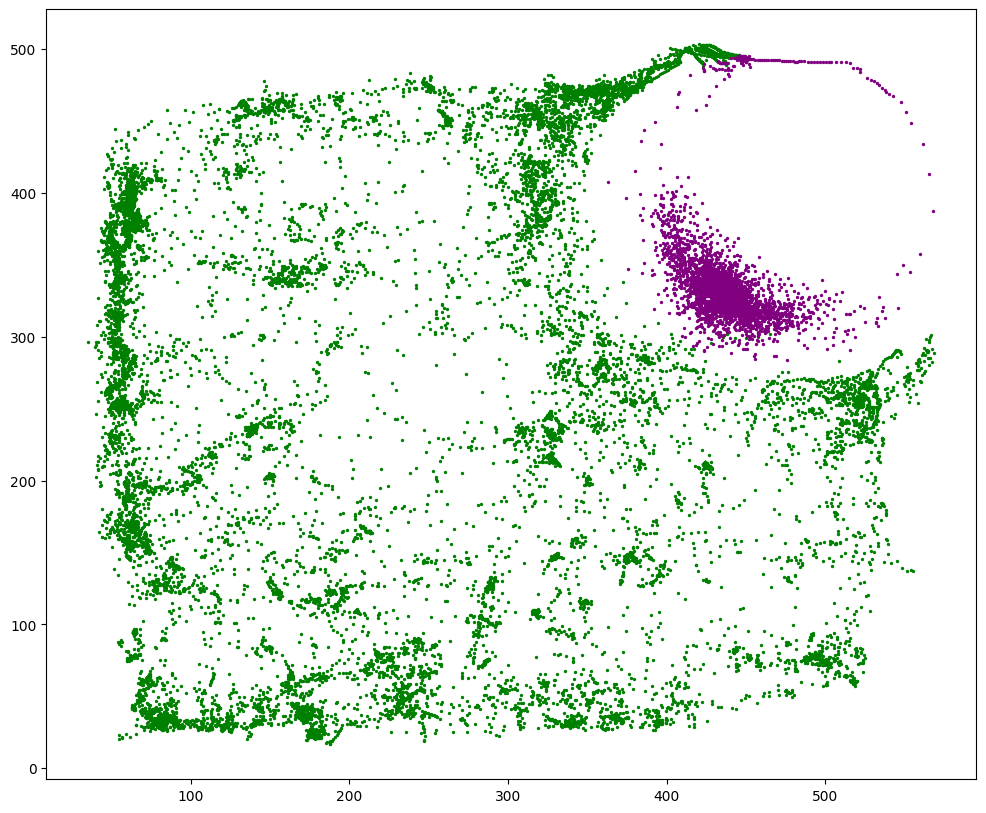

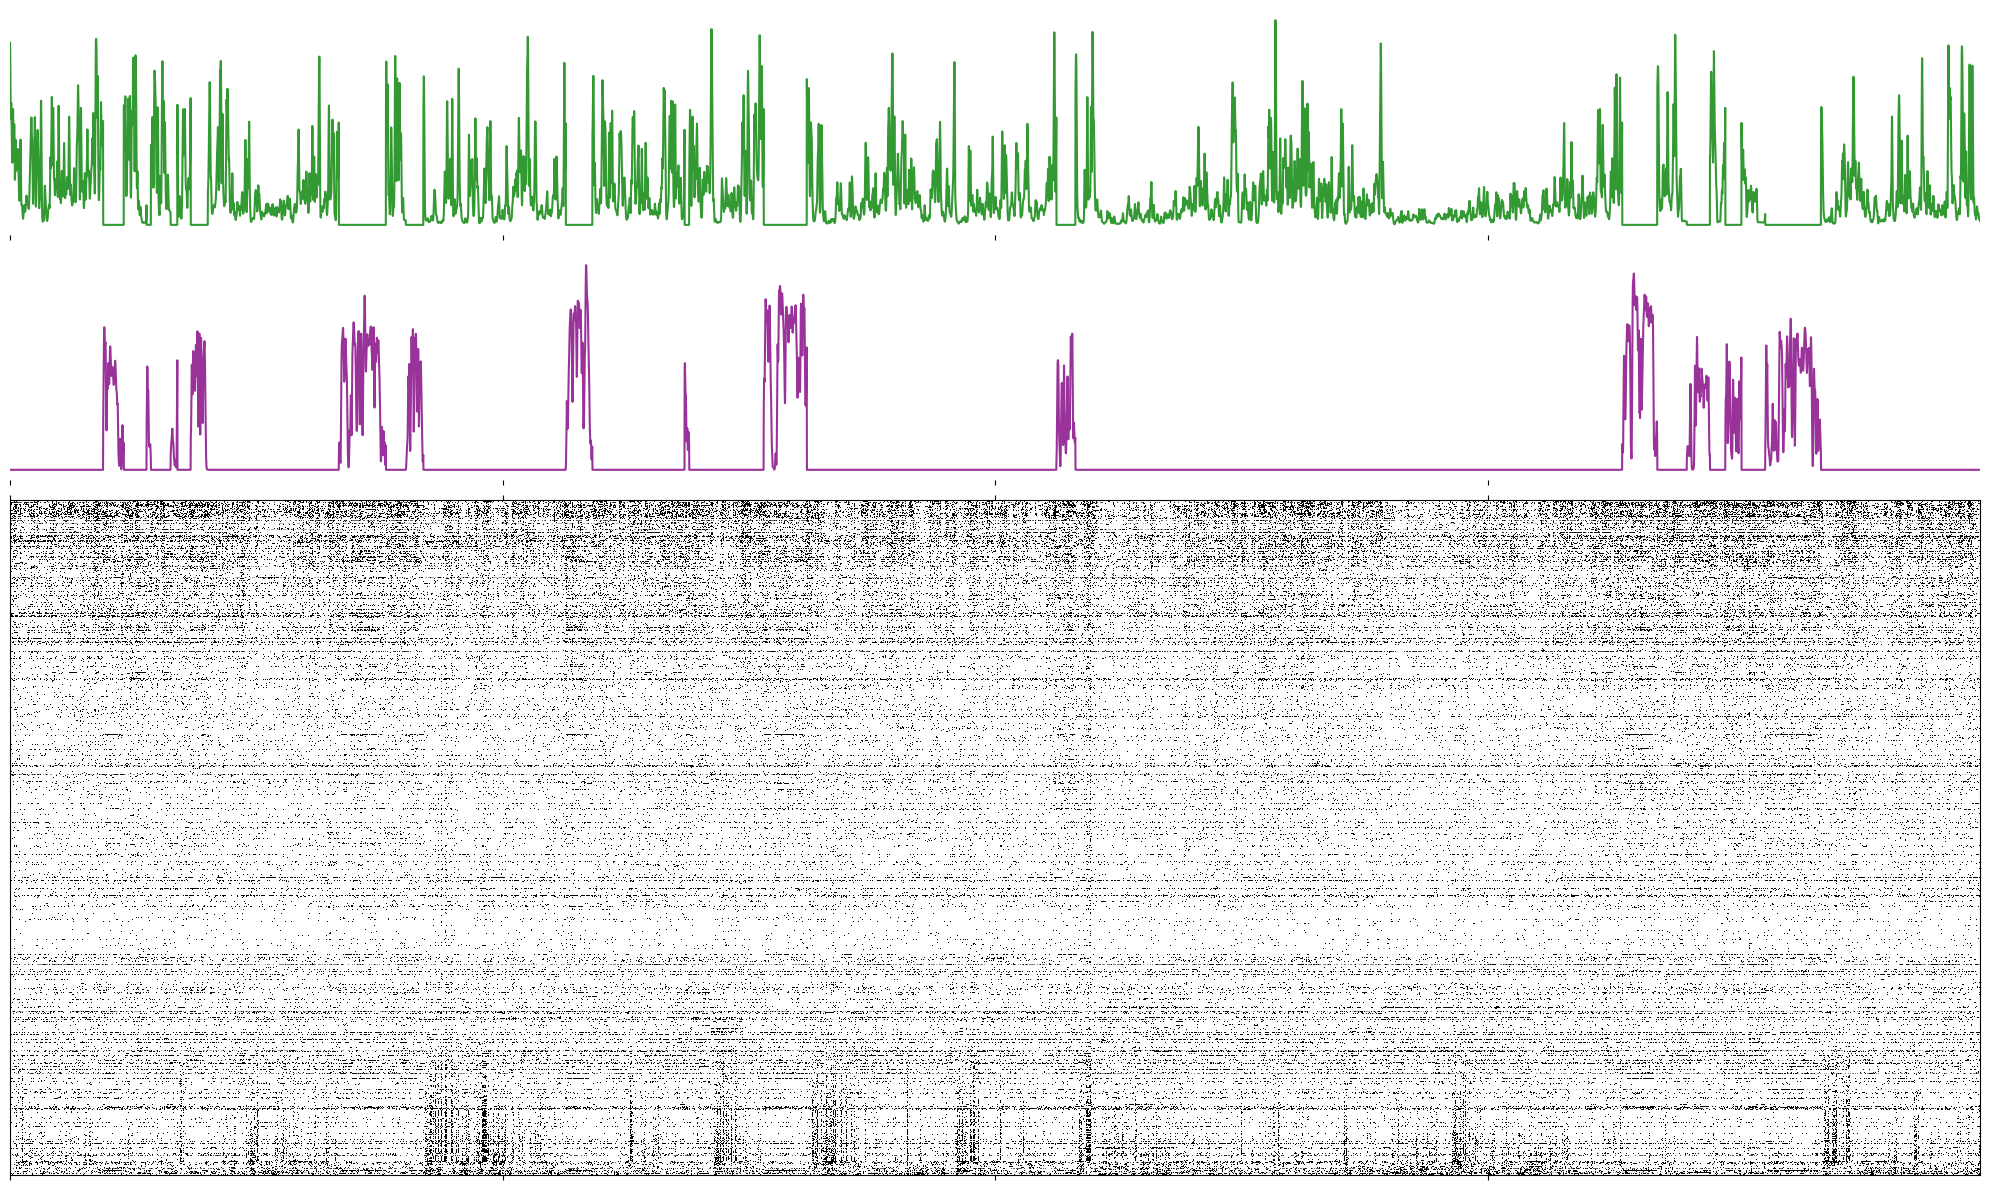

<Figure size 640x480 with 0 Axes>

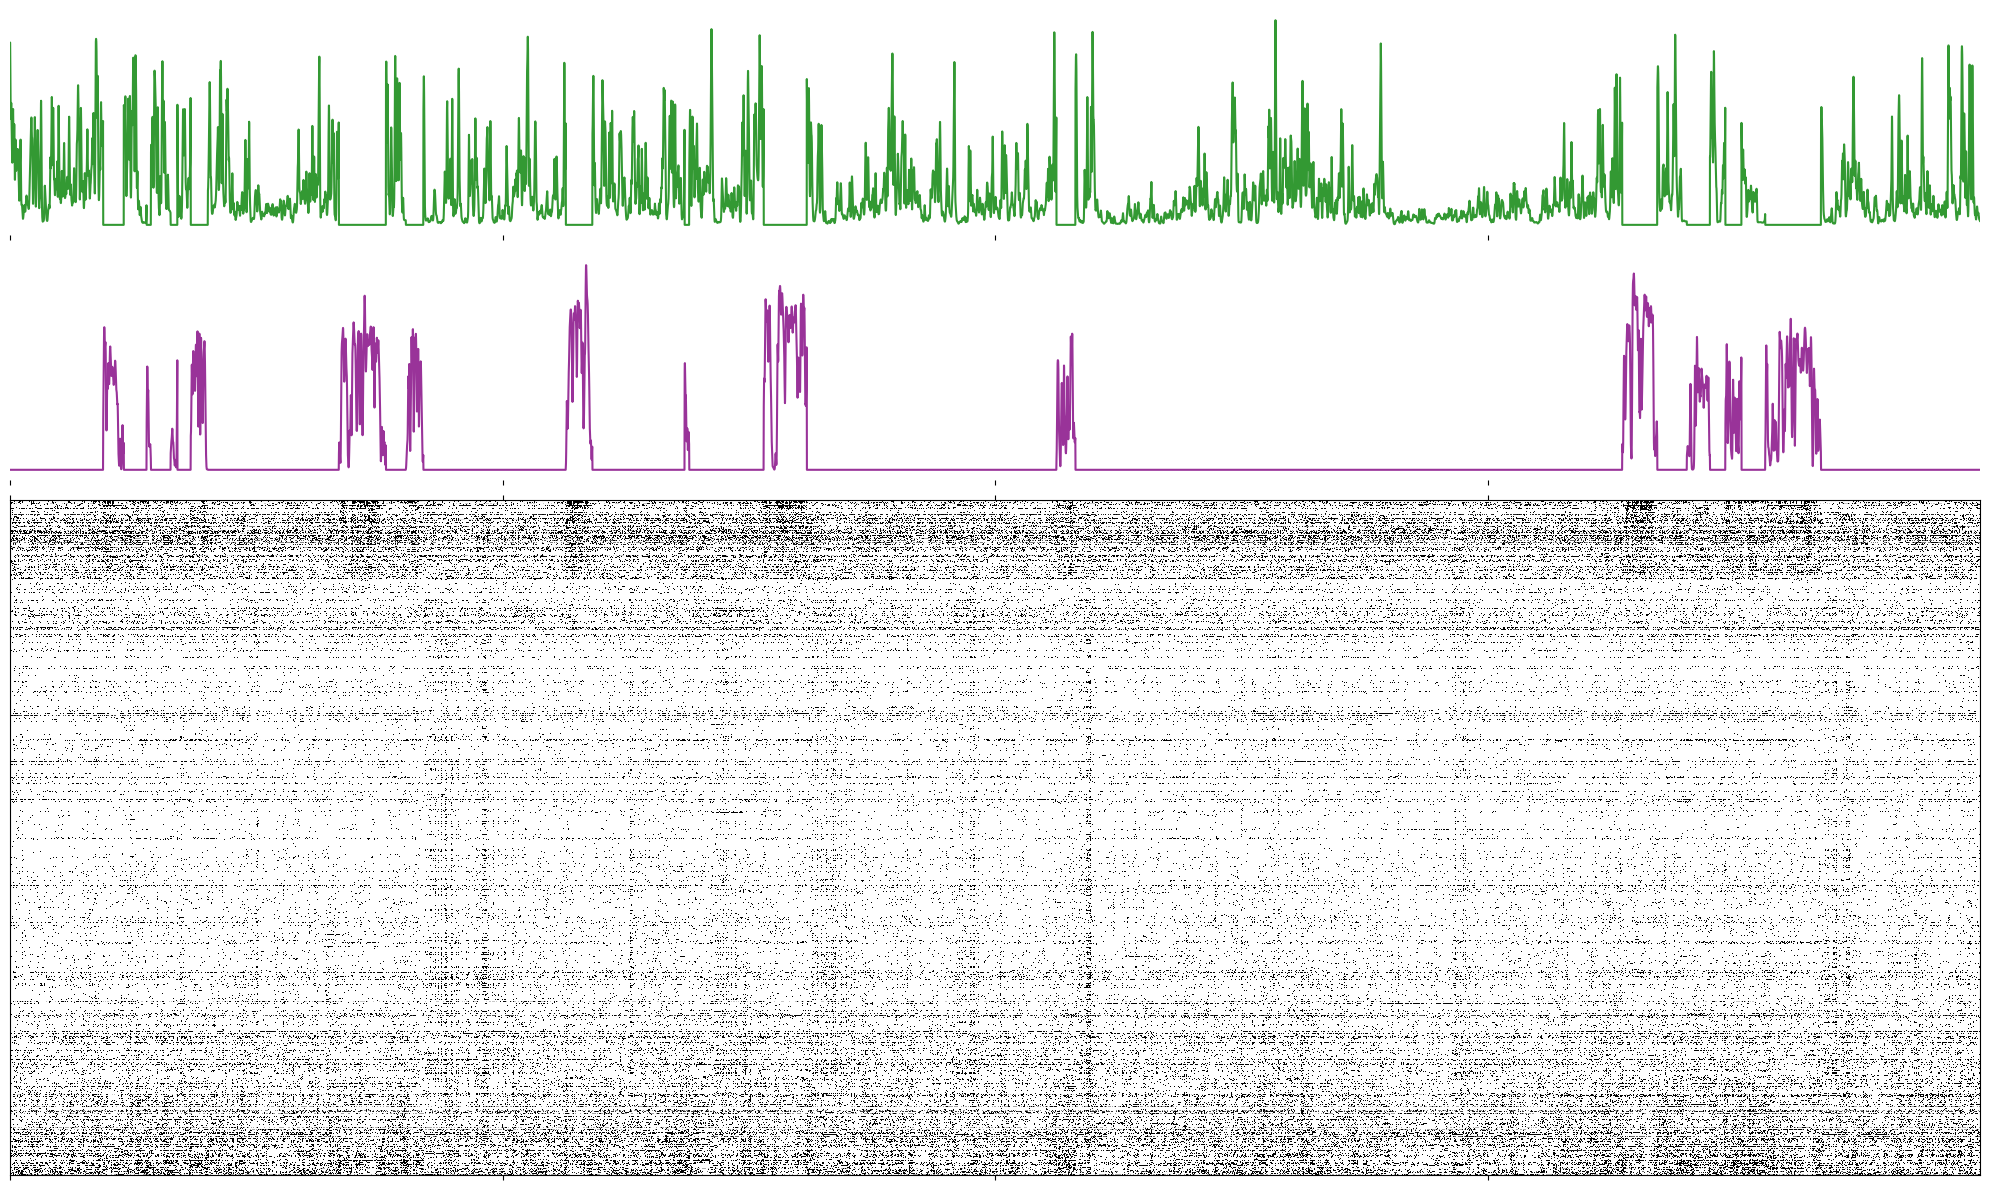

<Figure size 640x480 with 0 Axes>

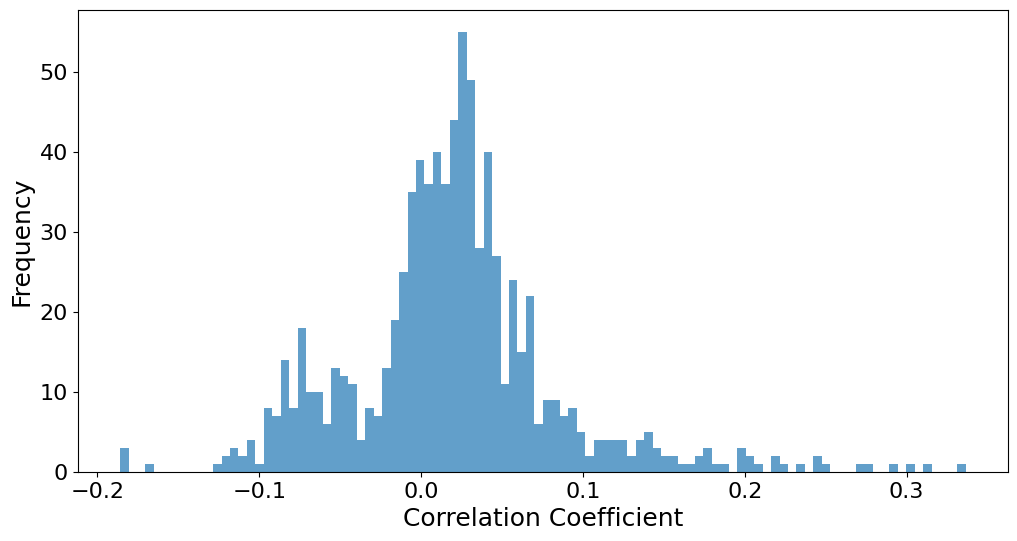

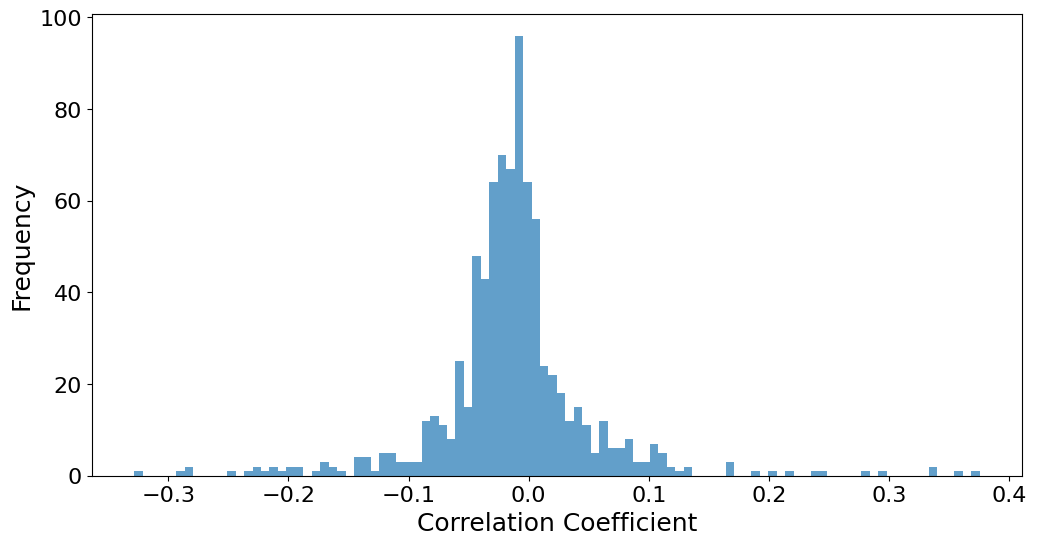

Correlation between free and wheel running neurons: -0.07201803698239351


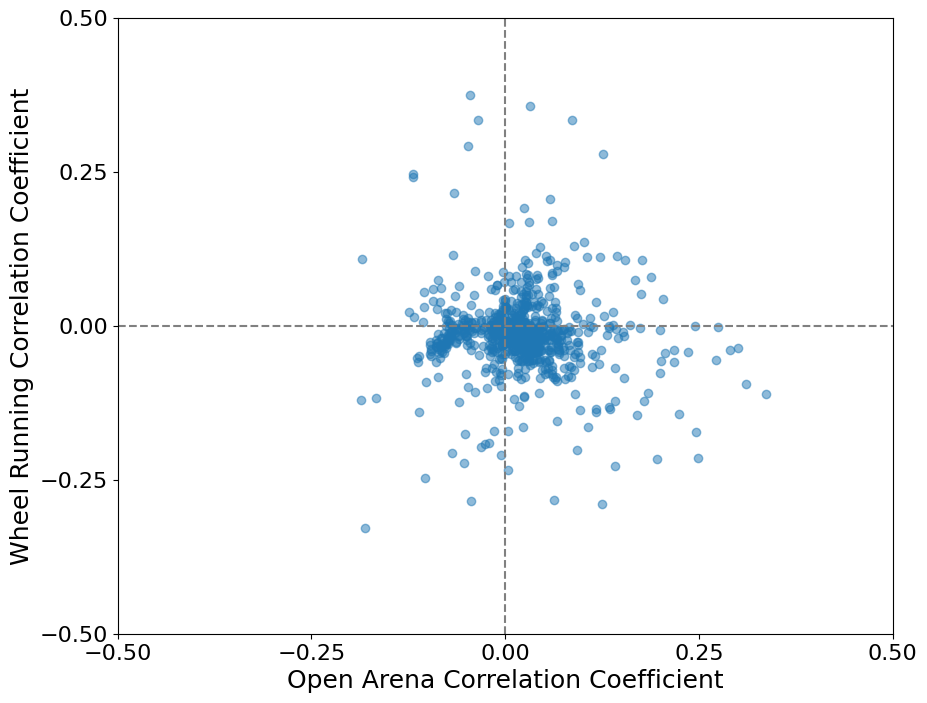

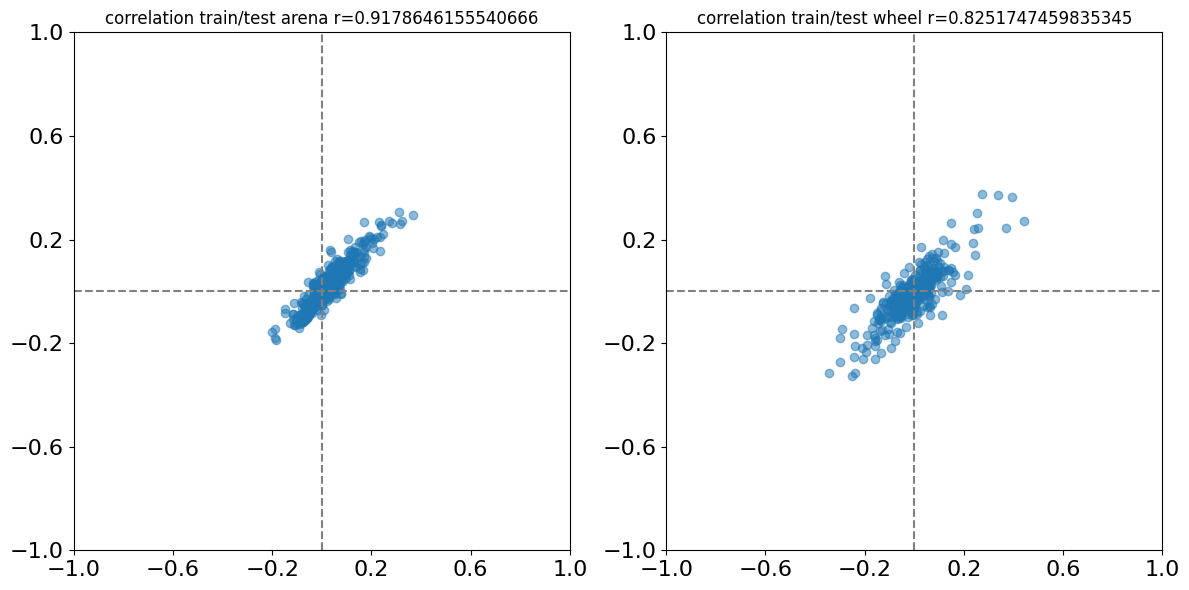

In [367]:
w_start = 0
w_end = 20000
plot_single_session(session, w_start=w_start, w_end=w_end)

In [ ]:
my_sessions = [
    ('AV043', '2024-03-04'),
    ('AV043', '2024-03-05'),
    ('AV043', '2024-03-08'),
    ('AV043', '2024-03-11'),
    ('AV043', '2024-03-13'),
    ('AV043', '2024-03-14'),
    ('AV043', '2024-03-26'),
    ('EB036', '2024-03-20'),
    ('EB036', '2024-03-22'),
    ('EB037', '2024-03-20'),
    ('EB037', '2024-03-21'),
    ('EB037', '2024-03-22'),
    ('GB011', '2024-05-09'),
    ('GB011', '2024-05-10'),
    ('GB011', '2024-05-14'),
    ('GB011', '2024-05-15'),
    ('GB011', '2024-05-16'),
    ('GB011', '2024-05-17'),
    ('GB012', '2024-06-20'),
    ('GB012', '2024-06-21'),
    ('GB012', '2024-06-25'),
    ('GB012', '2024-07-12'),
    ('GB012', '2024-07-16'),

    
]


results = analyze_multiple_sessions(my_sessions)


In [ ]:
results = categorise_neurons(results)

20


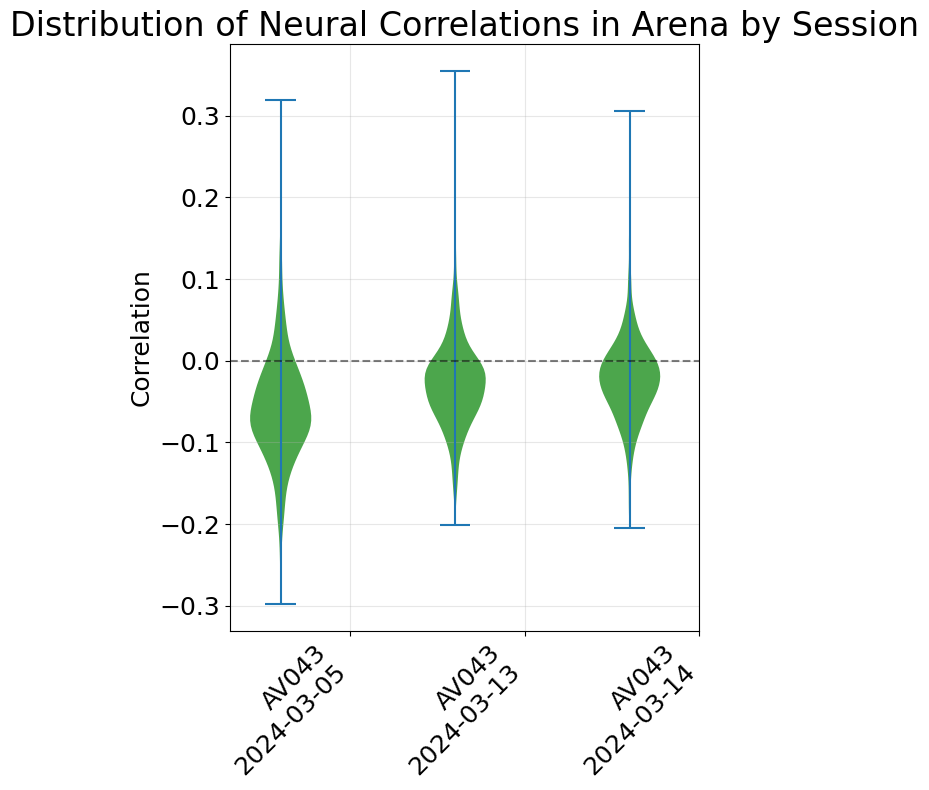

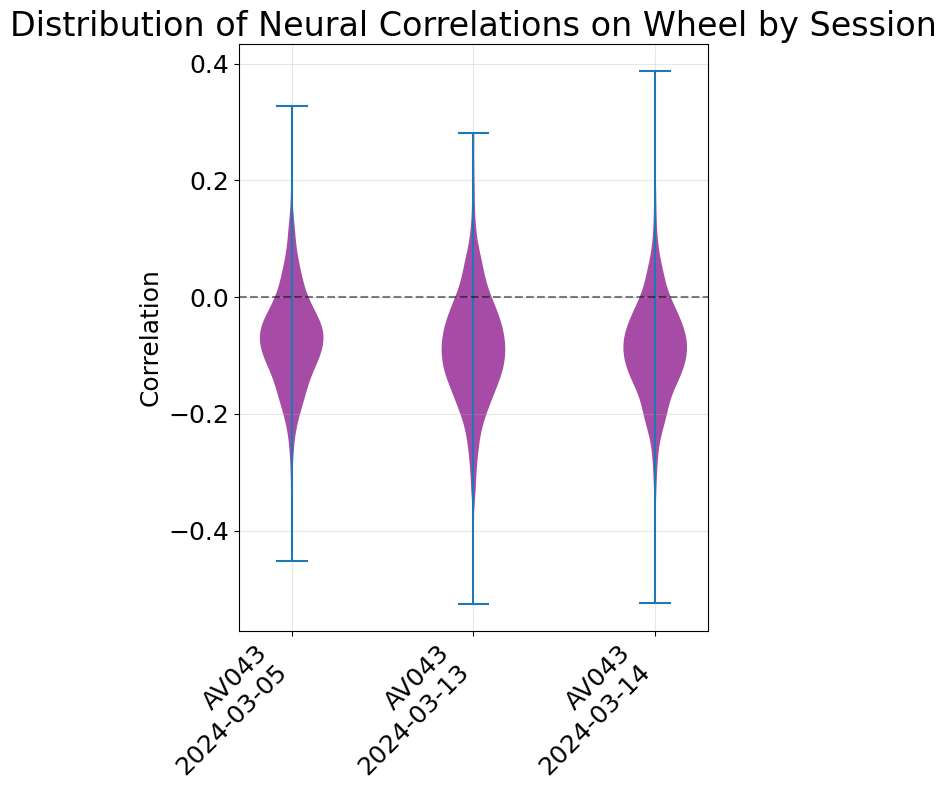

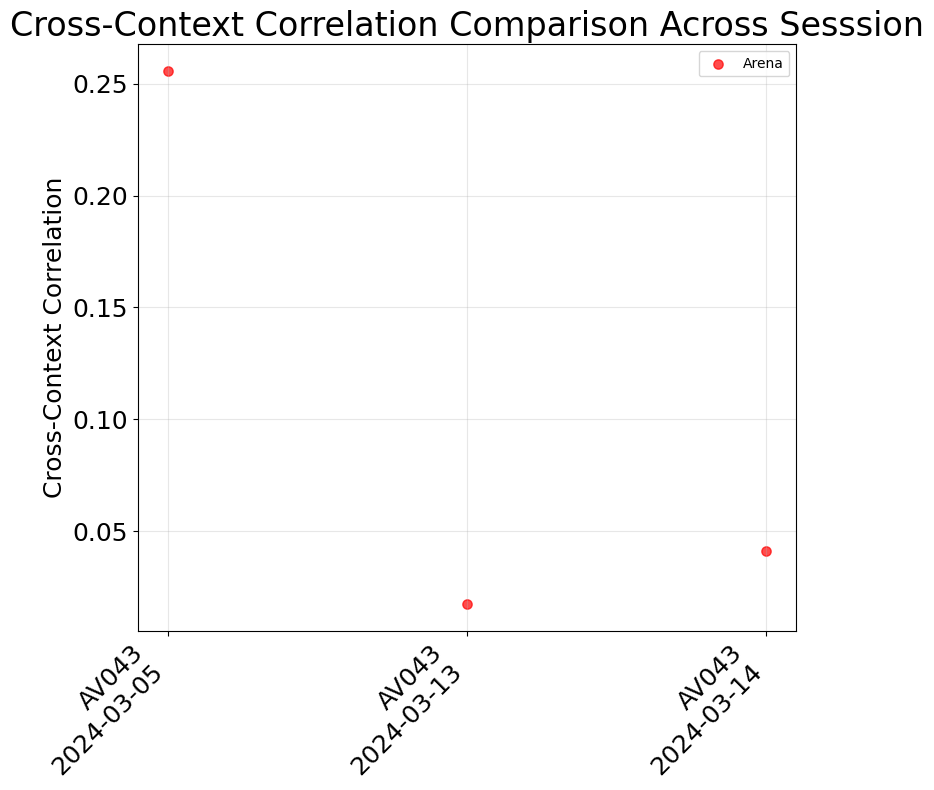

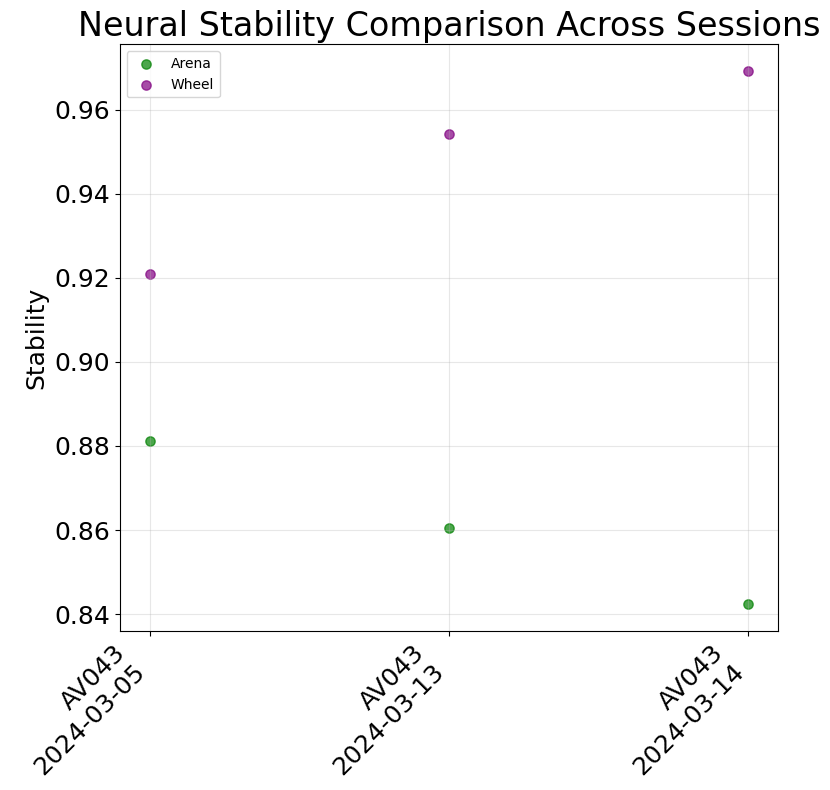

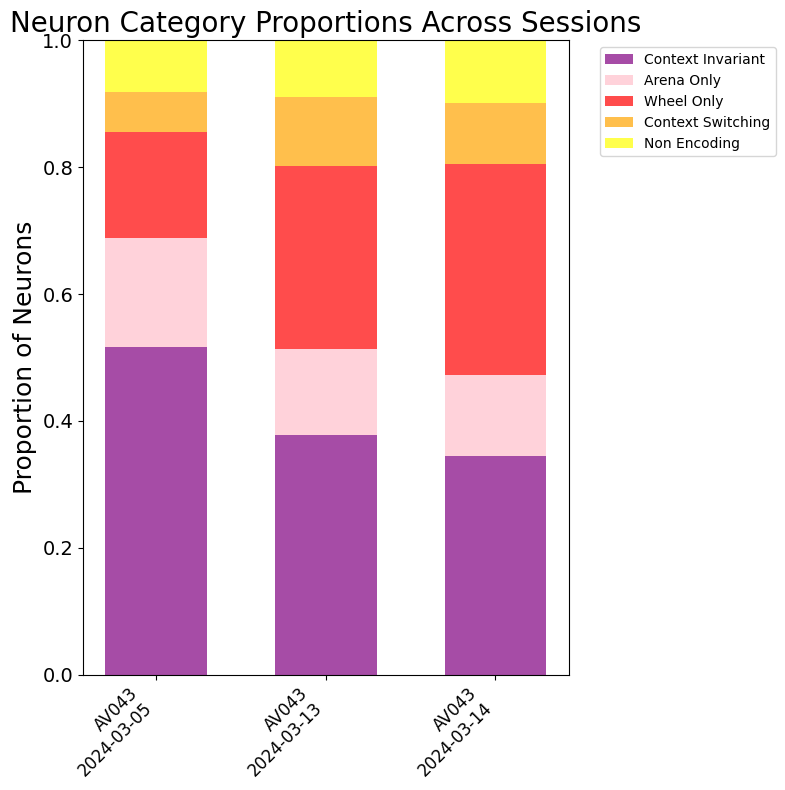

In [396]:
print(len(results))
selected_indices = [1, 4, 5]
selected_results = [results[i] for i in selected_indices]
plot_all_sessions(selected_results)

In [369]:
velocity = session["behavioral_data"]["velocity"]
wheel_velocity = session["behavioral_data"]["wheel_velocity"]
spike_counts = session["neural_data"]["spike_counts"]
arena_mask = session["behavioral_data"]["arena_mask"]
wheel_mask = session["behavioral_data"]["wheel_mask"]
cross_context = session["correlations"]["cross_context"]
subject = session["metadata"]["subject_id"]
date = subject = session["metadata"]["date"]

In [370]:
binsxneurons = spike_counts.T
binsxneurons = zscore(binsxneurons, axis=0)
pca = PCA(n_components = 10)
pctrajectories = pca.fit_transform(binsxneurons)





In [371]:
fullvel = np.zeros_like(arena_mask)
fullvell = velocity[arena_mask]
fullvel = wheel_velocity[wheel_mask]

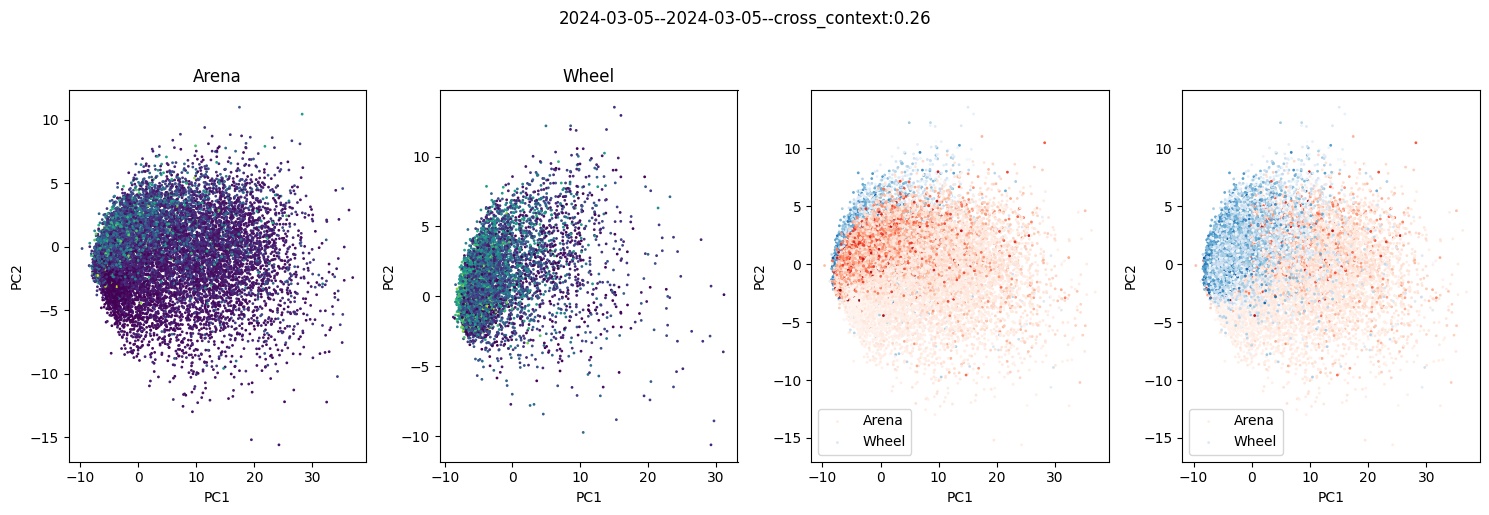

In [372]:
plt.figure(figsize=(15, 5))
plt.suptitle(f'{subject}--{date}--cross_context:{cross_context:.2f}', y=1.02)

plt.subplot(1,4,1)

arena_indices = np.where(arena_mask)[0]
plt.scatter(pctrajectories[arena_indices, 0],pctrajectories[arena_indices, 1], c=velocity[arena_mask], s=1, cmap="viridis")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Arena")

plt.subplot(1,4,2)
wheel_indices = np.where(wheel_mask)[0]
plt.scatter(pctrajectories[wheel_indices, 0],pctrajectories[wheel_indices, 1], c=wheel_velocity[wheel_mask], s=1, cmap="viridis")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("Wheel")


plt.subplot(1,4,3)

plt.scatter(pctrajectories[arena_indices, 0],pctrajectories[arena_indices, 1],c=velocity[arena_mask], label="Arena", s=1, cmap="Reds", zorder=2)
plt.scatter(pctrajectories[wheel_indices, 0],pctrajectories[wheel_indices, 1], c=wheel_velocity[wheel_mask], label="Wheel", s=1, cmap="Blues",zorder=1)
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.tight_layout()


plt.subplot(1,4,4)

plt.scatter(pctrajectories[arena_indices, 0],pctrajectories[arena_indices, 1],c=velocity[arena_mask], label="Arena", s=1, cmap="Reds")
plt.scatter(pctrajectories[wheel_indices, 0],pctrajectories[wheel_indices, 1], c=wheel_velocity[wheel_mask], label="Wheel", s=1, cmap="Blues")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()






In [209]:
n = 10
arenapccorrs = []
wheelpccorrs = []

for pc in range (n):
    arenacorr = np.corrcoef(pctrajectories[arena_mask,pc],velocity[arena_mask])[0,1]
    arenapccorrs.append(arenacorr)

    wheelcorr = np.corrcoef(pctrajectories[wheel_mask,pc],wheel_velocity[wheel_mask])[0,1]
    wheelpccorrs.append(wheelcorr)

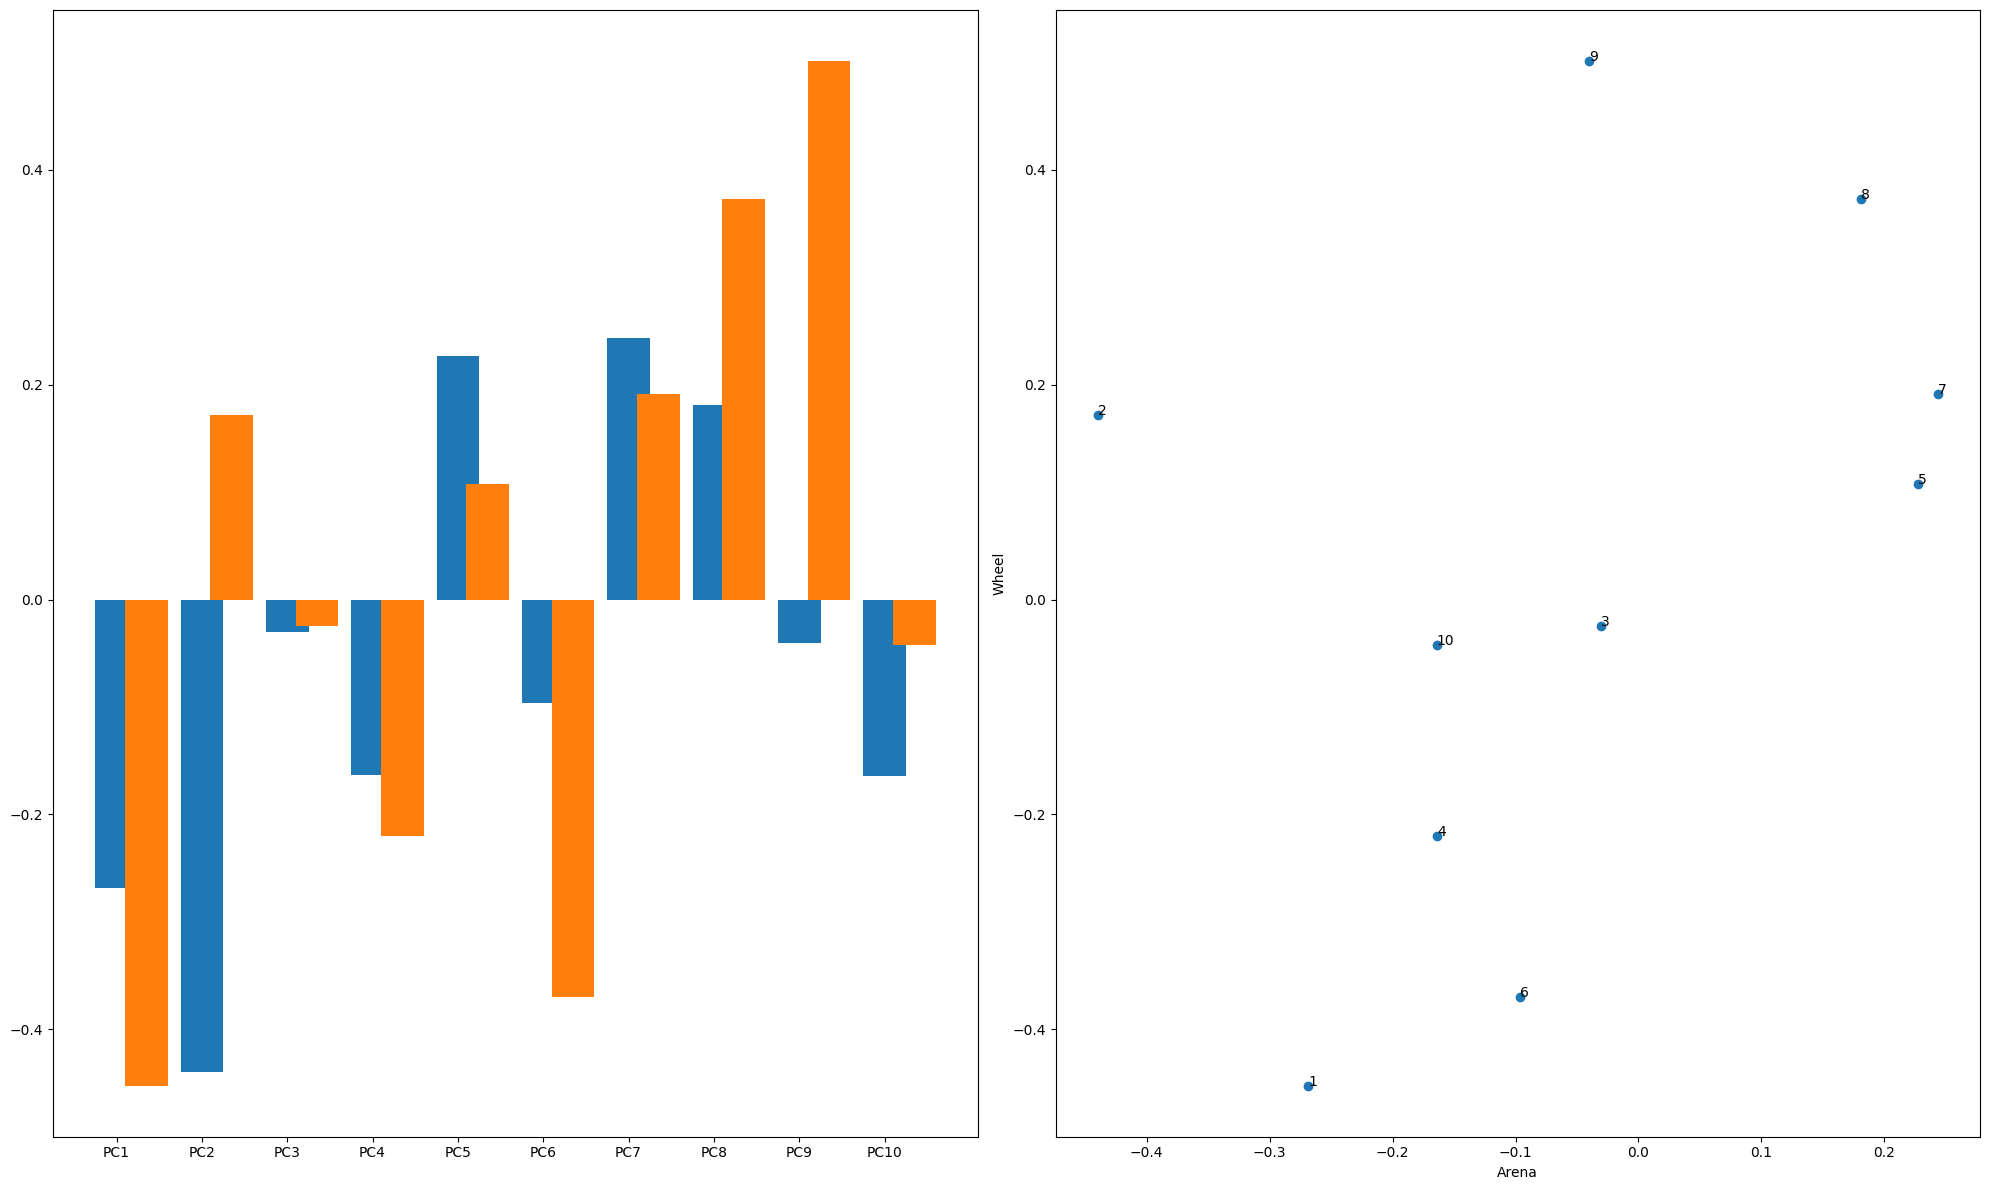

In [210]:
plt.figure(figsize=(20,12))

plt.subplot(1,2,1)
x = np.arange(n)
w = 0.35
plt.bar(x, arenapccorrs, label="Arena", width = 0.5)
plt.bar(x+w, wheelpccorrs, label="Wheel", width =0.5)
plt.xticks(np.arange(n), [f"PC{i+1}" for i in range(n)])

plt.subplot(1,2,2)
plt.scatter(arenapccorrs, wheelpccorrs)
for pc in range(n):
        plt.annotate(pc+1,(arenapccorrs[pc], wheelpccorrs[pc]))
plt.xlabel("Arena")
plt.ylabel("Wheel")
plt.tight_layout()
plt.show()

In [211]:
pcsgradient = 10
arenagr = np.array(arenapccorrs)
wheelgr = np.array(wheelpccorrs)

arenagrnorm = arenagr / np.linalg.norm(arenagr)
wheelgrnorm = wheelgr / np.linalg.norm(wheelgr)

gradientsimilarity = np.dot(arenagrnorm, wheelgrnorm)
gradientangle = np.arccos(np.clip(gradientsimilarity,-1, 1 ))*180/ np.pi

print(arenagrnorm)
print(wheelgrnorm)
print(gradientsimilarity)
print(gradientangle)

[-0.3900057  -0.63838462 -0.04373476 -0.23753814  0.32963363 -0.13992452
  0.35340931  0.26234242 -0.05875409 -0.23793404]
[-0.48770564  0.18532556 -0.0267825  -0.2374579   0.11561349 -0.39896858
  0.20640184  0.4018104   0.54041351 -0.04529473]
0.38079310207492767
67.61718212359735
